## Set up

Libraries used

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

The entire model class (for reference)

In [2]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv4.weight)

Creating an 'image' to test the model architecture with; this is a 500x500 image with 1 color band (like elevation), and I'm going to try to increase it to a 1500x1500 image (similar to the 30m -> 10m problem)

In [3]:
testing = np.zeros((1, 1, 500, 500))
testing = torch.from_numpy(testing)
testing = Variable(testing)
testing = testing.float()
testing

Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x1x500x500]

### The beginning image

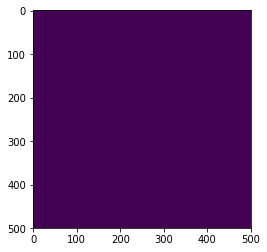

In [4]:
plt.imshow(testing.data.numpy().squeeze())

Testing the ReLU layer

In [5]:
relu_layer = nn.ReLU()
relu_output = relu_layer(testing)
relu_output

Variable containing:
( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of size 1x1x500x500]

Testing the convolution layers

In [6]:
upscale_factor = 3

c1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
c2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
c3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
c4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))

conv_output = c4(c3(c2(c1(relu_output))))
conv_output

Variable containing:
( 0 , 0 ,.,.) = 
  0.0007  0.0489  0.0554  ...   0.0503  0.0525  0.0663
 -0.0040  0.0285  0.0382  ...   0.0306  0.0426  0.0681
 -0.0027  0.0319  0.0414  ...   0.0329  0.0450  0.0731
           ...             ⋱             ...          
 -0.0022  0.0318  0.0431  ...   0.0335  0.0437  0.0739
  0.0119  0.0380  0.0508  ...   0.0408  0.0450  0.0648
  0.0104  0.0038  0.0093  ...   0.0062  0.0127  0.0360

( 0 , 1 ,.,.) = 
  0.0179  0.0408  0.0458  ...   0.0477  0.0422  0.0189
  0.0079  0.0255  0.0245  ...   0.0243  0.0199  0.0124
  0.0226  0.0434  0.0487  ...   0.0493  0.0387  0.0206
           ...             ⋱             ...          
  0.0221  0.0468  0.0480  ...   0.0491  0.0401  0.0207
  0.0063  0.0295  0.0256  ...   0.0251  0.0253  0.0152
  0.0085  0.0138  0.0091  ...   0.0054  0.0026 -0.0002

( 0 , 2 ,.,.) = 
 -0.0261 -0.0023 -0.0104  ...  -0.0093 -0.0101 -0.0223
 -0.0267 -0.0163 -0.0290  ...  -0.0303 -0.0287 -0.0437
 -0.0242 -0.0183 -0.0317  ...  -0.0269 -0.0319

Testing the pixel shuffle layer

In [7]:
shuffle_layer = nn.PixelShuffle(upscale_factor)

shuffle_output = shuffle_layer(conv_output)
shuffle_output

Variable containing:
( 0  , 0  ,.,.) = 
  0.0007  0.0179 -0.0261  ...   0.0663  0.0189 -0.0223
  0.0332  0.0905  0.0980  ...   0.0495  0.0464  0.0667
  0.0360  0.0340 -0.0156  ...   0.0291  0.0431 -0.0295
           ...             ⋱             ...          
  0.0104  0.0085 -0.0122  ...   0.0360 -0.0002 -0.0563
  0.0715  0.0640  0.1046  ...   0.0766  0.0725  0.0879
  0.0208  0.0366 -0.0060  ...   0.0157  0.0601 -0.0097
[torch.FloatTensor of size 1x1x1500x1500]

Testing the entire forward pass

In [8]:
forward_pass = shuffle_layer(
    c4(
        relu_layer(
            c3(
                relu_layer(
                    c2(
                        relu_layer(
                            c1(
                                testing))))))))

forward_pass

Variable containing:
( 0  , 0  ,.,.) = 
1.00000e-02 *
  2.0230 -0.3511 -2.8104  ...   3.7415  0.1819 -1.8503
  6.0912  5.5735  5.9634  ...   5.8286  5.5489  6.1350
  2.6886  5.2304  0.6409  ...   1.9164  4.1944 -0.1353
           ...             ⋱             ...          
  3.4465 -0.9198 -2.8652  ...   4.0042 -1.0400 -4.7428
  6.1761  5.6934  6.4677  ...   6.6250  4.4052  6.7090
  1.8133  4.7168  0.3814  ...   1.7068  5.1123  0.9729
[torch.FloatTensor of size 1x1x1500x1500]

### The output image

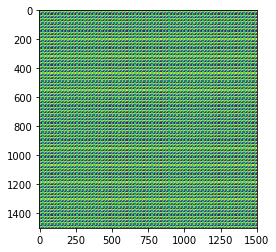

In [9]:
plt.imshow(forward_pass.data.numpy().squeeze())